<a href="https://colab.research.google.com/github/ssawant/ml-jupyter-notebook/blob/master/Pneumonia_Detection_using_Chest_X_Ray_Images_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"santoshsawant","key":"a1f1b349b891ec618054d1a8f5781bb4"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

# This permissions change avoid a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:13<00:00, 127MB/s]
100% 1.15G/1.15G [00:13<00:00, 94.1MB/s]


In [11]:
!unzip chest-xray-pneumonia.zip
!unzip -q chest_xray.zip
%ls

chest_xray		  chest_xray.zip  __MACOSX
chest-xray-pneumonia.zip  kaggle.json	  sample_data


In [0]:
# Basic
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf

# Tensorflow and Keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
filepath = '/content/chest_xray/'

train_dir = filepath + 'train/'
validation_dir = filepath + 'val/'
test_dir = filepath + 'test/'

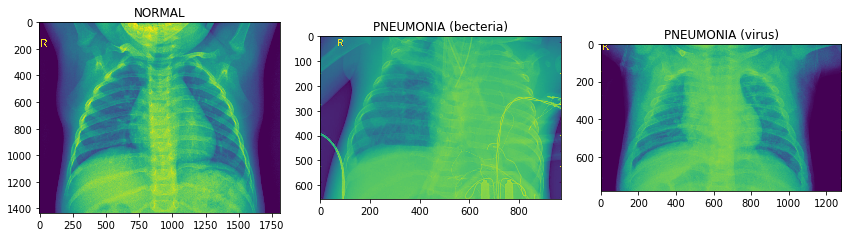

In [36]:
# Normal
img_normal = mpimg.imread(train_dir + 'NORMAL/IM-0119-0001.jpeg')
# Bacterial
imp_penumonia_bacteria = plt.imread(train_dir + 'PNEUMONIA/person1016_bacteria_2947.jpeg')
# virus
imp_penumonia_virus = plt.imread(train_dir + 'PNEUMONIA/person1018_virus_1706.jpeg')

# Plot configuration
plt.figure(figsize=(12,5))
plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal)
plt.subplot(1,3,2).set_title('PNEUMONIA (becteria)')
plt.imshow(imp_penumonia_bacteria)
plt.subplot(1,3,3).set_title('PNEUMONIA (virus)')
plt.imshow(imp_penumonia_virus)

plt.tight_layout()


In [0]:
# Two number of classes we are going to classify
# either Normal or Penumonia
NUM_CLASSES = 2

# Build the Model
def create_model(input_shape, num_classes):
  """
  Create the image classifier model on top of a pretrained
  Inception V3.

  Parameters
  ----------
  input_shape : tuple
      Shape tuple for Inception v3

  num_classes: Integer
      The number of classes that the classifier is 
      going to classify
  
  @return
      tensorflow model
  """
  # initialize a clean TF graph session
  K.clear_session()

  # Crete Inceotion v3 as base model
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

  # top up with custome layers for classifiction
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)

  # Freeze layer from training
  for layer in base_model.layers:
    layer.trainable = False
  
  # Add dense predictions layer with sigmoid activation
  predictions = Dense(num_classes, activation='sigmoid')(x)
  # Initialize the model
  model = Model(inputs=base_model.inputs, outputs=predictions)

  return model

In [49]:
model = create_model((150, 150, 3), NUM_CLASSES)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 1s 0us/step


In [51]:
# Training loss
training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)

# Training Accuracy
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('training_accuracy', dtype=tf.float32)

# Test Loss
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)

# Test Accuracy
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy', dtype=tf.float32)

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# Adam Optimizer
optimizer = Adam(lr=0.0001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
def dir_file_count(dir):
  return sum(len(files) for r, d, files in os.walk(dir))

In [57]:
# Configuration parameters
rescale = 1./255
target_size = (150, 150)
batch_size = 500
class_mode = 'categorical'

# argument the training dataset images
train_datagen = ImageDataGenerator(rescale=rescale, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, validation_split=0.2)

# Loading images in the generator
train_generator = train_datagen.flow_from_directory(train_dir, target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

# argument the validation dataset images
val_datagen = ImageDataGenerator(rescale=rescale)

# Loading the images in the generator
val_generator = val_datagen.flow_from_directory(validation_dir, target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)

# Argument the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale)

# Loading the images in the generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
